# Using Gurobi and Integer Linear Programming

<br>
In this notebook, you will learn the basics of linear programming in its simplest form while also getting a taste of interacting with the Gurobi Python API. This example is somewhat adapted from Gurobi, and there's some extra documentation to make learning the formalism less of a headache. This notebook assumes that Gurobi is properly installed with a valid license.

[Gurobi's Examples](https://www.gurobi.com/documentation/9.5/examples/example_tour.html)

[Read Here!](https://en.wikipedia.org/wiki/Integer_programming)


### Creating a Model
<br>
The Model object in Gurobi contains all the information regarding a linear programming problem. All variables and constraints are initialized inside this 'unsolved' state. Once we eventually optimize said problem, the solved state of the model can be queried for attributes.

In [1]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("2D Optimization")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-23


Linear programming problems maximize a linear objective function of a set of variables subject to a set of linear constraints. By utilizing simple functions, we can use solvers like Gurobi to organize problems with even millions of variables! As you will see in the scheduling tutorial, these variables can have unique and often clever 'physical' interpretations. 

In this example, we'll solve a system with just two variables (perhaps cartesian coordinates). This allows us to visualize the problem geometrically and get some intuition about linear programming. Say we wish to maximize the objective function (a *vector* in our 2 dimensional space):
<br>
<center>$4x + 3y$</center>
subject to the system of matrix inequalities:
<br>
<center>$2.5x + y \leq 10$</center>
<center>$0.5x + y \leq 3.8$</center>
<br>



### Variables

We initialize these in Gurobi using the addVar function. We need to specify the bounds of the parameters we will solve over using the built in variable types. In this example, we'll choose to only accept integer values, since they are the easiest to visualize. We specify the type of variable and assign it a name. Naming variables explicitly is important for querying later on.

In [2]:
# Create variables
x = m.addVar(vtype=GRB.INTEGER, name="x")
y = m.addVar(vtype=GRB.INTEGER, name="y")

### Constraints

Initializing constraints is similarly easy in Gurobi using the addConstr function. We specify the linear expression of our variables and again give it a convenient name. In our toy 2D model, it's fairly easy to visualize everything geometrically. Our constraints take the forms of lines that bound all of our feasible solutions.

In [3]:
# Add constraint: 2.5 x + y <= 10
m.addConstr(2.5*x + y <= 10, "c0")

# Add constraint: x + y >= 1
m.addConstr(0.5*x + y <= 3.8, "c1")

<gurobi.Constr *Awaiting Model Update*>

We can visualize using a 2D plot:

Text(0, 0.5, 'y')

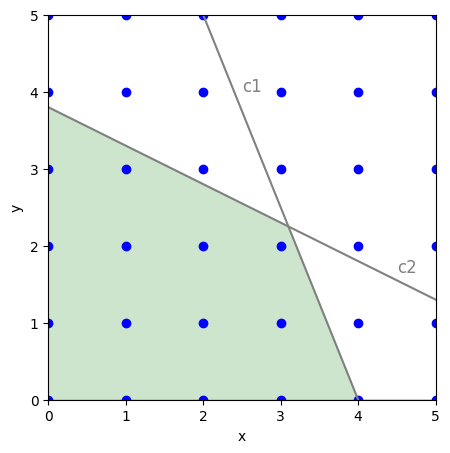

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

fig, axs = plt.subplots(figsize=(5,5))

X = np.arange(-1,7,.1)

#Plot constraints as lines
c0Y = 10-2.5*X
c1Y = 3.8-.5*X

axs.plot(X,c0Y,color='grey')
axs.text(2.5,4,'c1',color='grey',fontsize=12)

axs.plot(X,c1Y,color='grey')
axs.text(4.5,1.65,'c2',color='grey',fontsize=12)

#Fill in region that satisfies constraints
top = [min(*l) for l in zip(c0Y, c1Y)]
axs.fill_between(X,0,top,alpha=.2,color='g')
axs.set_ylim(-0,5)
axs.set_xlim(0,5)

points = [0,1,2,3,4,5]

#Plot integer solutions
for point in product(points,repeat=2):
    axs.scatter(point[0],point[1],color='blue')

axs.set_xlabel('x')
axs.set_ylabel('y')

### Objective

The setObjective function accepts another linear expression to optimize and an accompanying condition (i.e. maximize or minimize). We want to find the point on the surfaces of our planes that sits at the maximum of our objective function. Then, we need to find the nearest integer solutions for our variables.

In [5]:
# Set objective
m.setObjective(4*x + 3*y, GRB.MAXIMIZE)

We seek the combination of parameters that has maximal projection along the objective vector. By inspection, this looks like the point (3,2) below. We can also see, for example, that the point (4,3) better maximizes our objective but resides outside our feasible region.

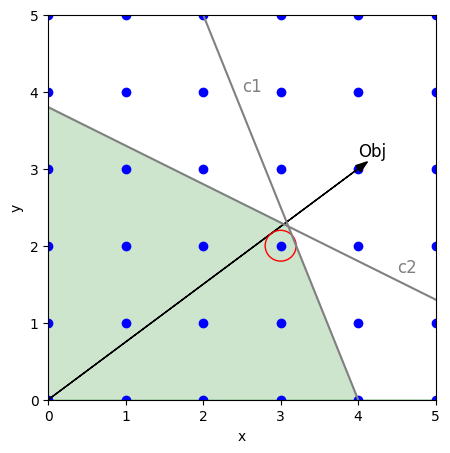

In [6]:
#Add pointer representing increasing objective
axs.arrow(0,0,4,3,color='black',head_width = .1)
axs.text(4,19/6,'Obj',fontsize=12)

#Circle our suspected solution
axs.add_patch(plt.Circle((3,2),.2,color='red',fill=False))
fig

Finally we call the optimize function. You can call this assuming you have enough constraints to bound your solution space and the objective is specified. The most common algorithm for solving ILP problems is the simplex algorithm. For larger problems, Gurobi will also attempt other methods and use what seems to be fastest.

[Simplex Algorithm](https://en.wikipedia.org/wiki/Simplex_algorithm)

In [7]:
# Optimize model
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x3d193bdd
Variable types: 0 continuous, 2 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [3e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+01]
Found heuristic solution: objective 16.0000000
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros
Variable types: 0 continuous, 2 integer (0 binary)

Root relaxation: objective 1.800000e+01, 0 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      18.0000000   18.00000  0.00%     -    0s

Explored 1 nodes (0 simplex iteration

### Solution

Gurobi's console output above contains statistics about the solving method and problem size. You will explore this in more depth in the scheduling tutorial. For now, let's just get our solution. We can query a completed model for variable values, optimization status and more.

In [8]:
# .VarName returns the assigned name, .X returns the calculated value from optimization
for v in m.getVars():
    print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

x 3
y 2
Obj: 18


As we expected, our best value of the objective subject to our matrix constraints and variable bounds occurs at (3,2). For scheduling, we rarely even care about the actual value of our abstract *objective*, only the parameters that achieve it!